# 📜Summary
**Introduction:** The client is a large grocery store in Ecuador that wants to be more efficient in stocking inventory.

**Problem:** If inventory is oversupplied, unsold items will go to waste and are cost to the grocery. If inventory is undersupplied, there wouldn't be enough items to sell that meets demand and they would miss the opportunity to earn more money.

**Hypothesis:** If we are able to know how much inventory to supply in a given day, then we would minimize the cost of oversupplying items that does not sell and goes to waste. And maximizing revenue by having enough supply of items that we know will be in demand.

**Goal:** To predict and forecast the inventory needed to meet the demand of market.

-----
[Kaggle](https://www.kaggle.com/code/fiftythirtyfour/store-sales/)

# >🪴Selfnotes
## 🌿Focus on Training Data first
I learned that you need to focus first on making great predictions on training data before doing any validation. If your model sucks at Training data, then it will not be any better at your test data.

## 🌿Separate models for Linear Regression
If you do Linear regression on features that are unrelated with each other, you get weird stuff. The reason is Linear Regression assumes that a feature relates with another. Grocery items does not relate with Lipstick. So there should be no reason why we should use 1 to predict the other. This is why we create models separately. You can still do the pipeline prep on all of them but the models must be trained and predicted separately.

## 🌿Be better than the Average
Always starting by visualizing the target data with the average line. This is what you need to beat. From a straight line average to a wiggly line model predictions that is closely hug the target values.

## 🌿Fast Iteration
Let your mind go fast. Remove all friction and self-doubt. Just code and explore. Allow yourself to see your code as tools for discovery and experimentation, not a rigid framework.

## 🌿Store 52
There is a new store that will not have sales by August of 2017. So, don't train model by store_nbr.

In [1]:
from IPython.display import HTML

iframe_code = """
<iframe 
    width="1000" height="1500" 
    src="https://lookerstudio.google.com/embed/reporting/11c536c1-3cdd-4efd-b071-53ddf8b8edb4/page/8tZ1D" 
    frameborder="0" style="border:0" allowfullscreen 
    sandbox="
        allow-storage-access-by-user-activation 
        allow-scripts 
        allow-same-origin 
        allow-popups 
        allow-popups-to-escape-sandbox">
</iframe>
"""

display(HTML(iframe_code))

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 400
import warnings
warnings.filterwarnings('ignore')

## Load
df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
## Clean

def getSalesBand(d):
    k = pd.cut(d.groupby('store_nbr')['sales'].mean()
           , bins=[0, 200, 500, 800, 1000, float('inf')]
           , labels=[1,2,3,4,5]
           , right=False
          )
    return k.to_dict()

def cleanData(a, st, oi, ho, sb):
    a['date'] = pd.to_datetime(a['date'])
    a['year'] = a['date'].dt.year
    a['weekname'] = a.date.dt.day_name()
    a['month'] = a.date.dt.month
    a['weeknum'] = a['date'].dt.isocalendar().week
    a['dayofyear'] = a['date'].dt.strftime('%j').astype(int)
    a['store_nbr'] = a['store_nbr']
    a['store_type'] = a['store_nbr'].map(st)
    a['oil_price'] = a['date'].map(oi)
    a['holidays'] = a['date'].map(ho)
    a['sales_band'] = a['store_nbr'].map(sb)
    return a

transactions['date'] = pd.to_datetime(transactions['date'])
stores['cluster'] = stores['cluster'].astype(str)
store_type = dict(zip(stores['store_nbr'], stores['type']))

oil['date'] = pd.to_datetime(oil['date'])
oil['inv_oil'] = 1/oil['dcoilwtico']
oil_price = dict(zip(oil['date'], oil['inv_oil']))

holidays['date'] = pd.to_datetime(holidays['date'])
holidays = holidays.query('transferred == False')
holidays['count'] = 1
holidays.groupby('date')['count'].max()
holidays = dict(zip(holidays['date'], holidays['count']))

sales_band = getSalesBand(df)

df = cleanData(df, store_type, oil_price, holidays, sales_band)

## Organize
target = 'sales'
cat = [x for x in df.columns if df.dtypes[x] == 'object']
num = [x for x in df.columns if df.dtypes[x] in ('int64', 'float64')]
num.remove('id')
num.remove('sales')

## train test split
train = df.loc[~df['date'].dt.year.isin([2013, 2017])]
test = df.loc[df['date'].dt.year == 2017]

# 🤓Data

# > Store Bands
I need to find a better way to group stores based on their volume.

In [3]:
g = train
g.groupby(['sales_band', 'store_nbr'])[target].mean().dropna()

sales_band  store_nbr
1           10            179.612439
            12            197.908010
            13            202.887081
            16            210.059909
            21            173.984566
            22             71.335150
            26            141.924167
            29            191.718138
            30            140.225755
            32            106.962354
            35            149.192541
            42            163.028721
            52              0.000000
            54            206.766004
2           1             272.083565
            2             419.395364
            4             365.169018
            5             297.348142
            6             482.271320
            7             523.739902
            9             499.152961
            14            209.883160
            15            216.561679
            17            341.826897
            18            241.605086
            19            252.247203
            20  

# > Understanding the Holidays
Ignore the transferred holidays because they were not celebrated on that day.

In [4]:
g = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
g = g.loc[pd.to_datetime(g['date']).dt.year == 2016]
g['date'] = pd.to_datetime(g['date'])
# g['weekname'] = pd.to_datetime(g['date']).dt.day_name()
# g['month'] = g['date'].dt.month
# g['year'] = g['date'].dt.year
g = g.query('transferred == False')
g['count'] = 1

g = g.groupby('date')['count'].max()
# g.resample()
g.groupby('date').sum()

date
2016-01-01    1
2016-02-08    1
2016-02-09    1
2016-03-02    1
2016-03-25    1
2016-04-01    1
2016-04-12    1
2016-04-14    1
2016-04-16    1
2016-04-17    1
2016-04-18    1
2016-04-19    1
2016-04-20    1
2016-04-21    1
2016-04-22    1
2016-04-23    1
2016-04-24    1
2016-04-25    1
2016-04-26    1
2016-04-27    1
2016-04-28    1
2016-04-29    1
2016-04-30    1
2016-05-01    1
2016-05-02    1
2016-05-03    1
2016-05-04    1
2016-05-05    1
2016-05-06    1
2016-05-07    1
2016-05-08    1
2016-05-09    1
2016-05-10    1
2016-05-11    1
2016-05-12    1
2016-05-13    1
2016-05-14    1
2016-05-15    1
2016-05-16    1
2016-05-27    1
2016-06-23    1
2016-06-25    1
2016-07-03    1
2016-07-23    1
2016-07-24    1
2016-08-05    1
2016-08-12    1
2016-08-15    1
2016-08-24    1
2016-09-28    1
2016-10-07    1
2016-10-09    1
2016-11-02    1
2016-11-03    1
2016-11-04    1
2016-11-06    1
2016-11-07    1
2016-11-10    1
2016-11-11    1
2016-11-12    1
2016-11-25    1
2016-11-28    1
201

In [5]:
import pandas as pd

# Load data and convert 'date' to datetime
g = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
g['date'] = pd.to_datetime(g['date'])

# Filter for the year 2017
g = g[g['date'].dt.year == 2017]

# Set count to 1 for holidays
g['count'] = 1

# Group by date and take the max count
g = g.groupby('date')['count'].max()

# Set index to datetime, fill missing dates with 0, and calculate cumulative sum
g = g.asfreq('D').fillna(0)

# Identify changes in holiday occurrence
changes = (g.diff().fillna(0) != 0).cumsum()

# Reset cumulative sum to zero for new holidays
g = g.groupby(changes).cumsum()

print(g)


date
2017-01-01    1.0
2017-01-02    2.0
2017-01-03    0.0
2017-01-04    0.0
2017-01-05    0.0
2017-01-06    0.0
2017-01-07    0.0
2017-01-08    0.0
2017-01-09    0.0
2017-01-10    0.0
2017-01-11    0.0
2017-01-12    0.0
2017-01-13    0.0
2017-01-14    0.0
2017-01-15    0.0
2017-01-16    0.0
2017-01-17    0.0
2017-01-18    0.0
2017-01-19    0.0
2017-01-20    0.0
2017-01-21    0.0
2017-01-22    0.0
2017-01-23    0.0
2017-01-24    0.0
2017-01-25    0.0
2017-01-26    0.0
2017-01-27    0.0
2017-01-28    0.0
2017-01-29    0.0
2017-01-30    0.0
2017-01-31    0.0
2017-02-01    0.0
2017-02-02    0.0
2017-02-03    0.0
2017-02-04    0.0
2017-02-05    0.0
2017-02-06    0.0
2017-02-07    0.0
2017-02-08    0.0
2017-02-09    0.0
2017-02-10    0.0
2017-02-11    0.0
2017-02-12    0.0
2017-02-13    0.0
2017-02-14    0.0
2017-02-15    0.0
2017-02-16    0.0
2017-02-17    0.0
2017-02-18    0.0
2017-02-19    0.0
2017-02-20    0.0
2017-02-21    0.0
2017-02-22    0.0
2017-02-23    0.0
2017-02-24    0.0
2017-

# > Beating the Average
If I just used the average, what would it look like? The model that I will build must be better than the average. What the hell is the point if I cannot be better than the average.

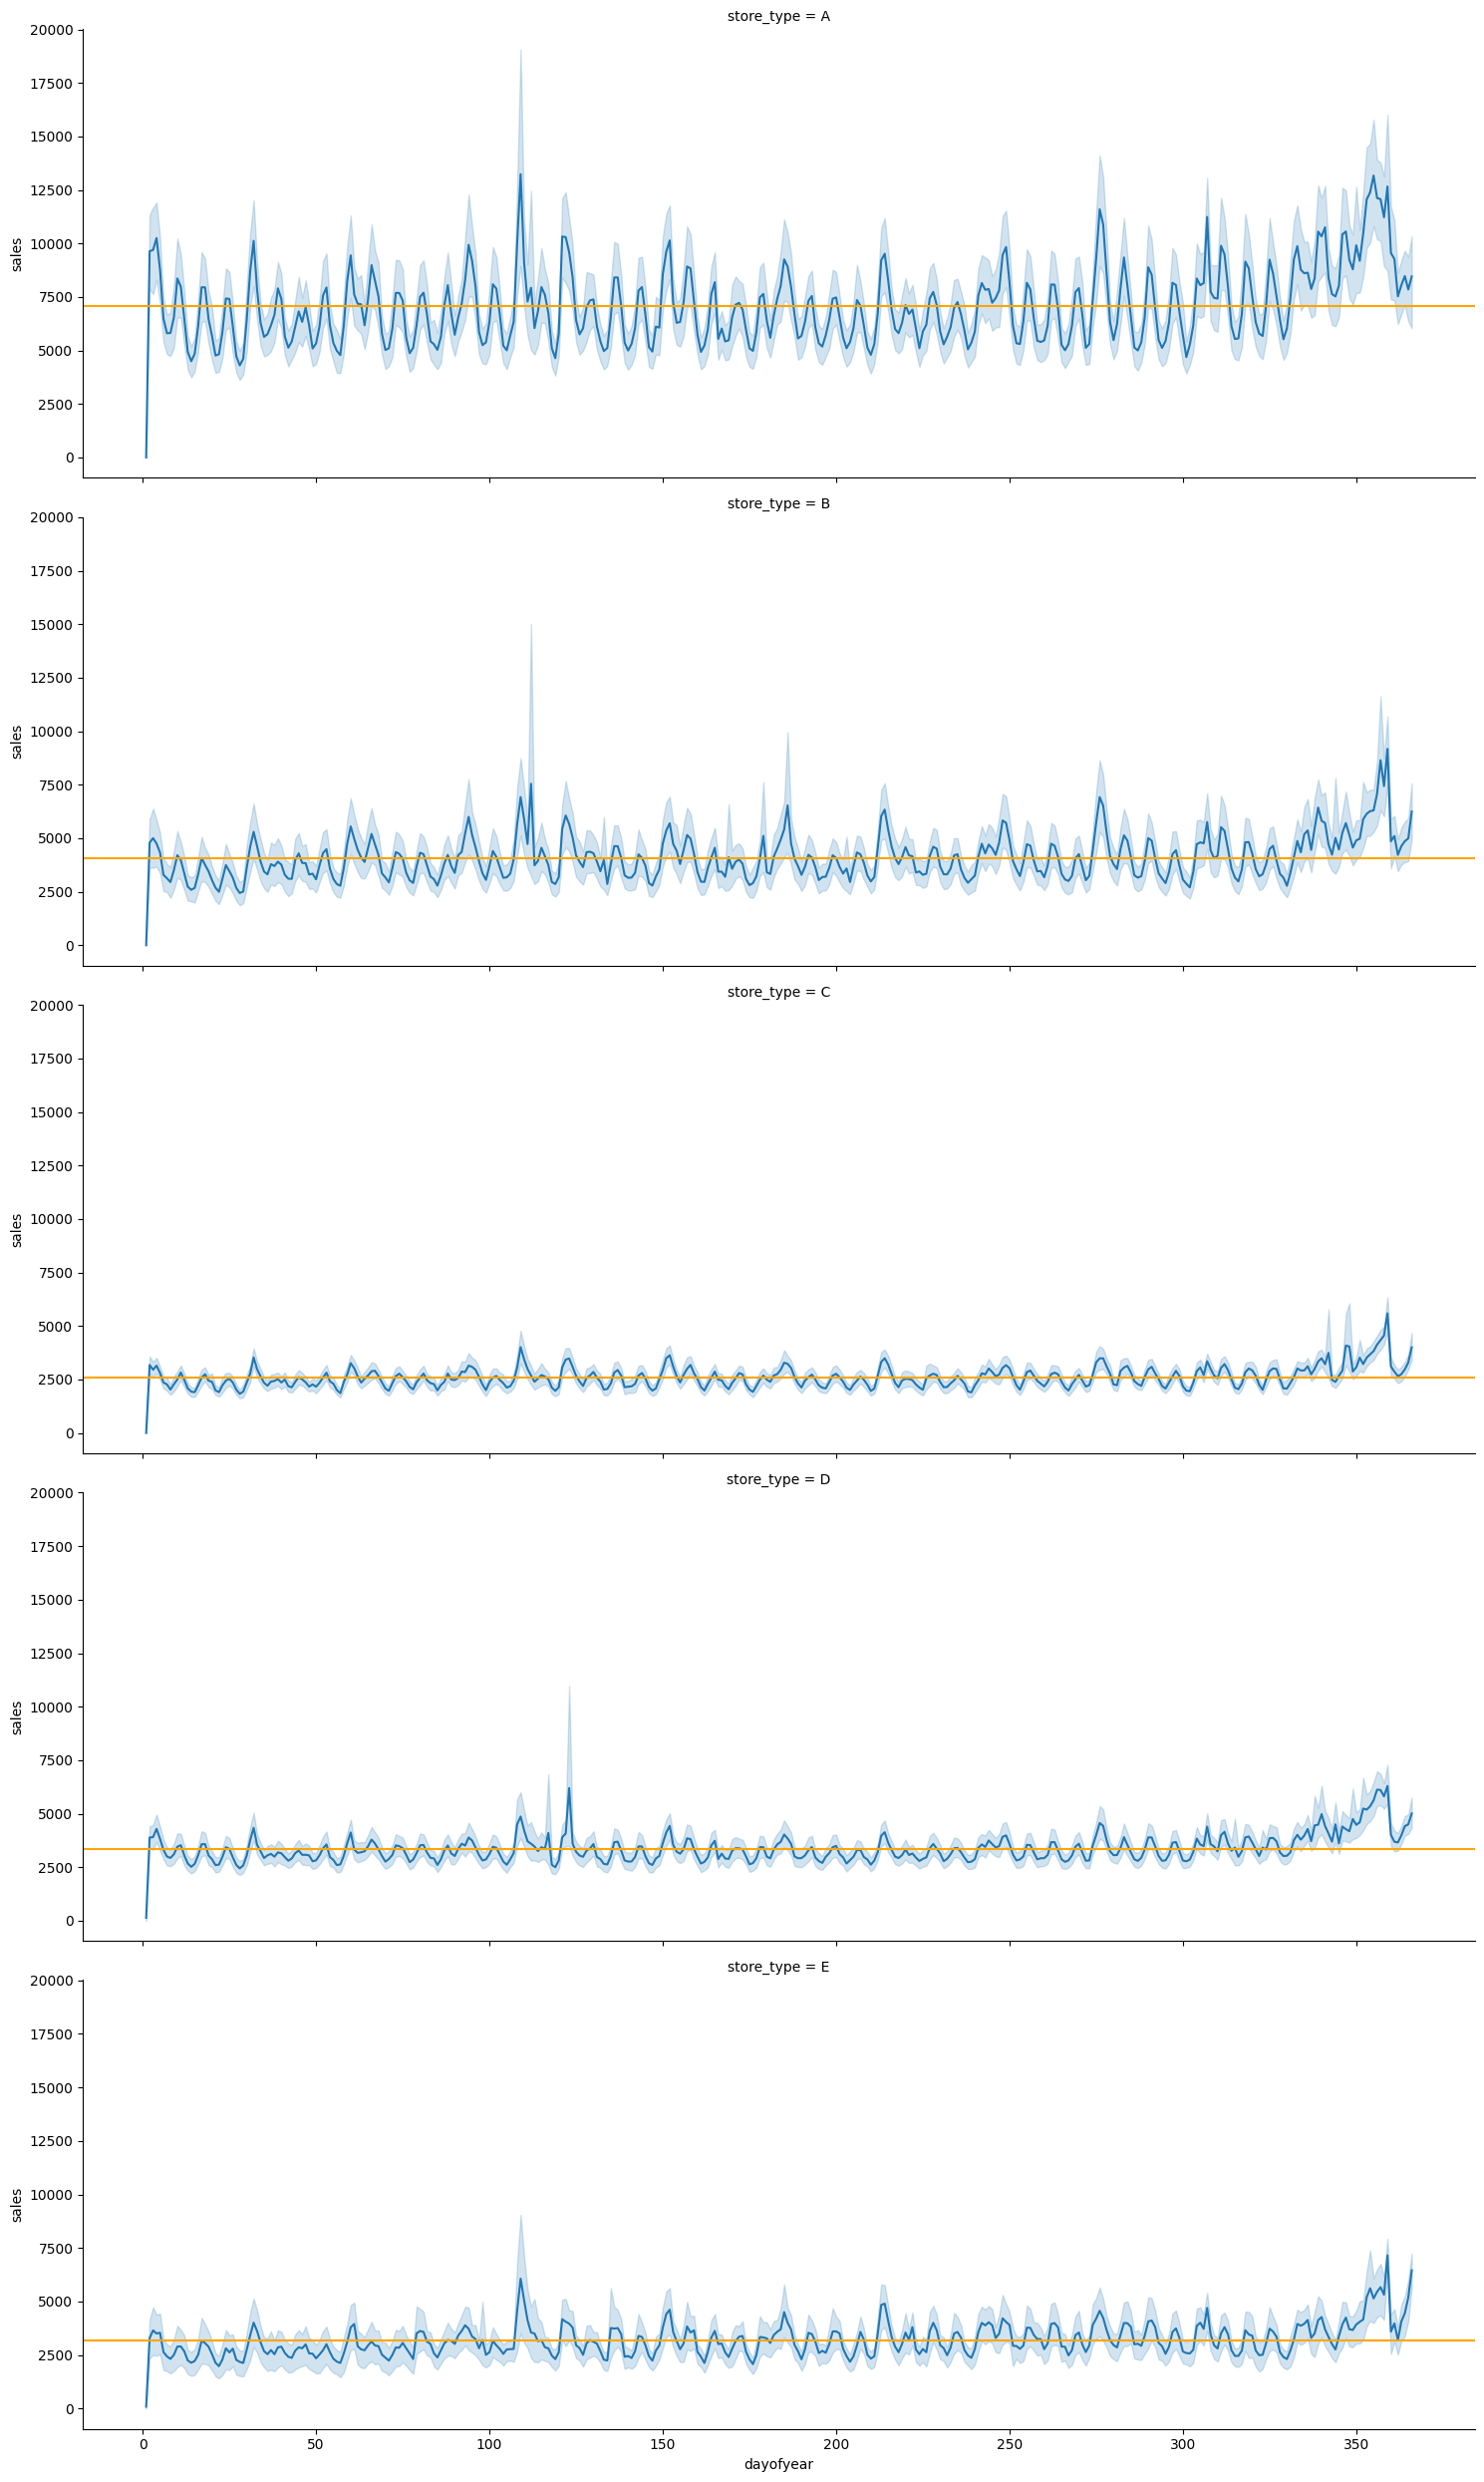

CPU times: user 58.8 s, sys: 523 ms, total: 59.3 s
Wall time: 58.6 s


In [6]:
%%time
d = train.query("family== 'GROCERY I'") ## Focus on GROCERY I
d['store_type'] = d['store_nbr'].map(store_type)
g = d.groupby('store_type') ## Use groupby as an function object
m = g[target].mean() ## Easier to get means

h = sns.relplot(d, x='dayofyear', y=target
                , row='store_type', row_order=list('ABCDE') ## Graph timeseries by store_type
                , kind='line', aspect=3)

## Since I have relplot as an FacetGrid, I can get the axes
## individually and map mean as an axhline for each
## store_type.
for ax, mean in zip(h.axes.flat, m):
    ax.axhline(y=mean, color='orange')

plt.show()

## The goal is to be comfortable at looking for a category
## that fits the target. And see if it is worth adding
## into the model.

# > Items with largest volume and volatility
Type A stores have more data. Will focus on this. Now, I need to see which products have the largest volume and deviations. The products that have low volume and does not have big swings, I will just use the average or zeros.

In [7]:
%%time
g = train.query('store_type=="A"')
g = g.groupby('family')[target].agg(['sum', 'std'])
g.sort_values(['sum'], ascending=False )

CPU times: user 167 ms, sys: 2.95 ms, total: 170 ms
Wall time: 170 ms


,sum,std
family,,
GROCERY I,6.948780e+07,4128.244862
BEVERAGES,4.980825e+07,3473.010256
PRODUCE,3.527928e+07,3683.801989
CLEANING,1.832562e+07,1000.936294
DAIRY,1.613206e+07,940.274508
POULTRY,9.231635e+06,575.024603
BREAD/BAKERY,8.635977e+06,497.575158
MEATS,7.827470e+06,448.563508
PERSONAL CARE,5.184757e+06,350.195670


# 🤖Model

# > Pipes

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, att, store_type, oil_price, holidays, sales_band):
        self.att = att
        self.store_type = store_type
        self.oil_price = oil_price
        self.holidays = holidays
        self.sales_band = sales_band
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = cleanData(X, self.store_type, self.oil_price, self.holidays, self.sales_band) ## Find this at Top.
        return X[self.att]
    
num_pp = Pipeline([
    ('dataselect', DataSelect(
        ['onpromotion', 'weeknum', 'oil_price', 'holidays', 'sales_band']
        , store_type, oil_price, holidays, sales_band)
    )
    , ('impute', SimpleImputer(strategy='mean'))
    , ('scaler', StandardScaler())
])

cat_pp = Pipeline([
    ('dataselect', DataSelect(
        ['weekname', 'month']
        , store_type, oil_price, holidays, sales_band)
    )
    , ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

pipe = FeatureUnion([
    ('numeric', num_pp)
    , ('cat', cat_pp)
])

In [9]:
%%time
pipe.fit(train);
# train_pp = pipe.transform(train)
# test_pp = pipe.transform(test)

CPU times: user 35.6 s, sys: 899 ms, total: 36.5 s
Wall time: 36.2 s


# > Baseline

In [10]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def trainModels(d):
    ms = {}
    for member in d['family'].unique():
        for store in d['sales_band'].unique():
            trn = d.loc[(d['family'] == member) & (d['sales_band'] == store)]
            x_val = pipe.transform(trn)
            y_val = trn[target]
            model = Ridge(100)
            model.fit(x_val, y_val)
            ms[member+'|'+store.astype(str)] = model
    return ms

def makePredictions(d, mod):
    pr = []
    for member in d['family'].unique():
        for store in d['sales_band'].unique():
            trn = d.loc[(d['family'] == member) & (d['sales_band'] == store)]
            x_val = pipe.transform(trn)
            pr.append(pd.Series(mod[member+'|'+store.astype(str)].predict(x_val), index=trn.index))
    return pd.concat(pr)

In [11]:
def getScores(d, m, p):
    return np.sqrt(
        - cross_val_score(
            m[d['family'].iloc[0]+'|'+d['sales_band'].iloc[0].astype(str)]
            , p.transform(d)
            , d[target]
            , scoring='neg_mean_squared_error'
        ).mean()
    )

In [12]:
%%time
models = trainModels(train)

CPU times: user 2min 20s, sys: 34.9 s, total: 2min 55s
Wall time: 1min 55s


# > Residuals. Make orange closer to blue dots.

In [13]:
g = train.groupby(['family', 'sales_band']).apply(getScores, models, pipe)#.sort_values(ascending=False)
g.xs(1, level='sales_band').sort_values(ascending=False)

family
GROCERY I                     1458.570544
BEVERAGES                      801.668981
PRODUCE                        504.538358
CLEANING                       439.685177
DAIRY                          207.961657
BREAD/BAKERY                   154.116588
MEATS                          131.650809
HOME CARE                      111.198311
FROZEN FOODS                   110.321094
PERSONAL CARE                  107.783911
DELI                           103.934598
EGGS                            98.920758
POULTRY                         86.198768
LIQUOR,WINE,BEER                75.244694
PREPARED FOODS                  28.188592
HOME AND KITCHEN I              15.644256
HOME AND KITCHEN II             14.752826
GROCERY II                       8.240928
CELEBRATION                      5.769928
LADIESWEAR                       4.817848
SEAFOOD                          4.234157
LINGERIE                         4.158556
LAWN AND GARDEN                  3.833719
AUTOMOTIVE                 

In [14]:
g = test.groupby(['family', 'sales_band']).apply(getScores, models, pipe)#.sort_values(ascending=False)
g.xs(1, level='sales_band').sort_values(ascending=False)

family
GROCERY I                     1451.994888
BEVERAGES                     1154.810384
PRODUCE                       1017.399735
CLEANING                       649.817933
DAIRY                          294.862413
BREAD/BAKERY                   216.542799
PERSONAL CARE                  108.704482
MEATS                           99.716603
EGGS                            98.998935
POULTRY                         98.481391
DELI                            97.583370
HOME CARE                       94.371409
FROZEN FOODS                    71.741365
LIQUOR,WINE,BEER                66.146946
PREPARED FOODS                  43.716639
LAWN AND GARDEN                 21.977923
HOME AND KITCHEN I              18.376991
HOME AND KITCHEN II             16.573949
GROCERY II                      13.755775
SCHOOL AND OFFICE SUPPLIES      12.813853
CELEBRATION                      6.777714
LADIESWEAR                       6.630107
PLAYERS AND ELECTRONICS          6.385749
SEAFOOD                    

CPU times: user 2.59 s, sys: 1.42 s, total: 4.02 s
Wall time: 1.59 s


Text(0, 0.5, 'Predictions')

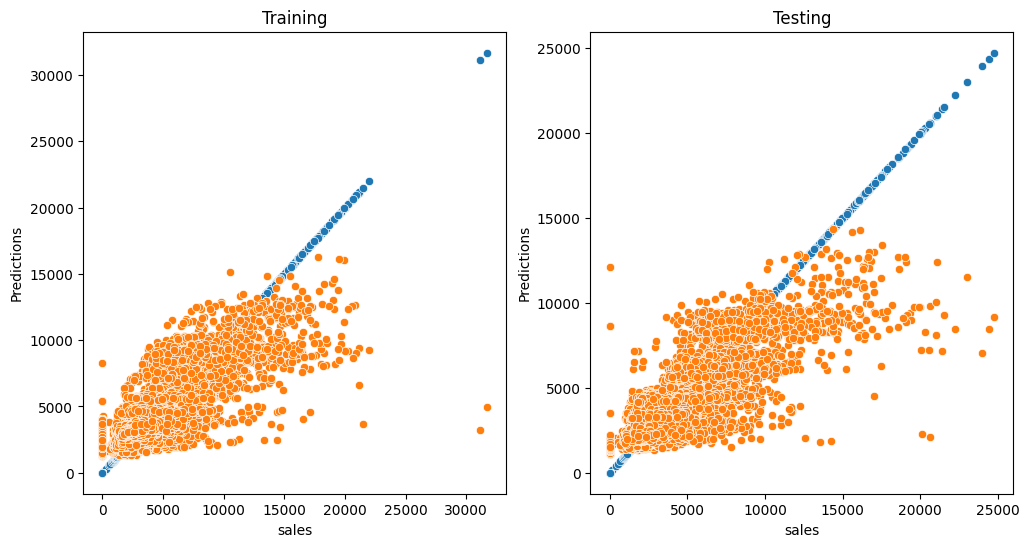

In [15]:
%%time
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
g = train.query('family == "GROCERY I"').copy()
g = g.query('year == 2016')
g = g.query('store_nbr not in (45,44,1,2,3,4,5,9,7,12,20)') ## f*cking outliers
g
sns.scatterplot(g, x=target, y=target, ax=ax[0]);
sns.scatterplot(g, x=target, y=makePredictions(g, models), ax=ax[0]);
## improve this. you are in the right direction.
ax[0].set_title('Training')
ax[0].set_ylabel('Predictions')

g = test.query('family == "GROCERY I"').copy()
g = g.query('store_nbr not in (45,44,1,2,3,4,5,9,7,12,20)') ## f*cking outliers
g
sns.scatterplot(g, x=target, y=target, ax=ax[1]);
sns.scatterplot(g, x=target, y=makePredictions(g, models), ax=ax[1]);
ax[1].set_title('Testing')
ax[1].set_ylabel('Predictions')

# sns.scatterplot(x=g[target],y=makePredictions(g, models), hue='year');
## improve this. you are in the right direction.

# > Predicted Demand vs Actual Sales
Why are the predictions lower than actual? I think it is because the predictions accounts for all types of stores. The lower volume stores are dragging the average down.

CPU times: user 15.9 s, sys: 1.1 s, total: 17 s
Wall time: 15.2 s


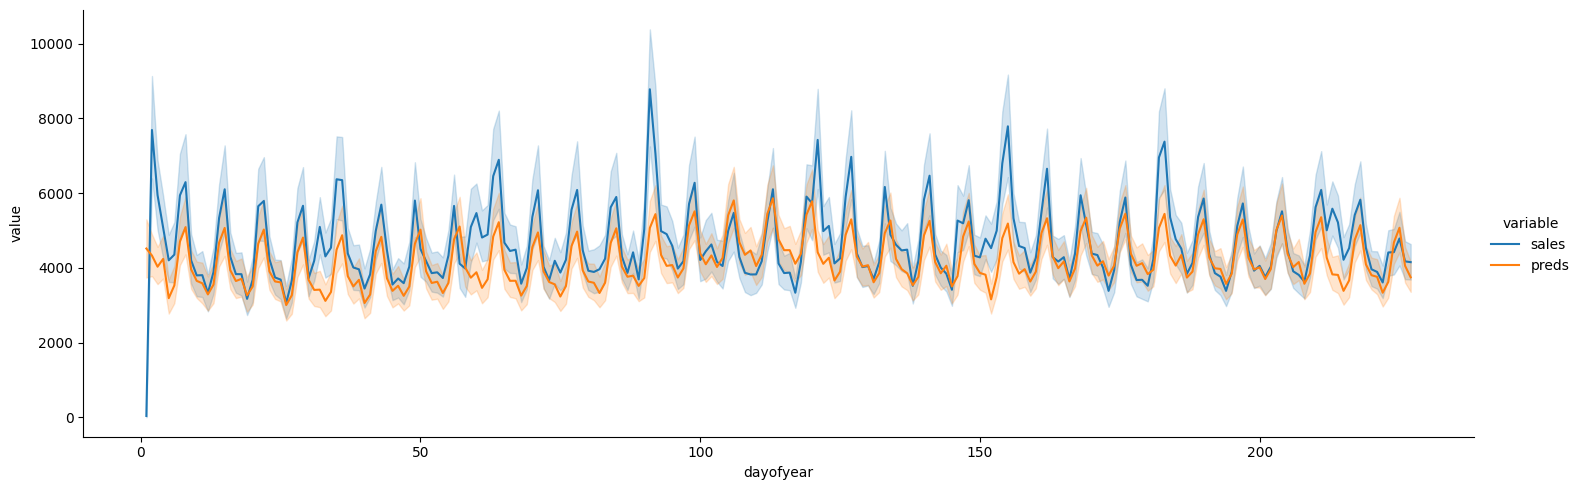

In [16]:
%%time
g = test.copy()
g = g.query('family == "GROCERY I"')
g['preds'] = makePredictions(g, models)

g = g[['store_nbr', 'sales', 'preds', 'dayofyear']]
g = pd.melt(g, id_vars=['store_nbr', 'dayofyear'])

sns.relplot(g, x='dayofyear', y='value', hue='variable'
            , kind='line', aspect=3);

CPU times: user 1min 55s, sys: 1.68 s, total: 1min 57s
Wall time: 1min 55s


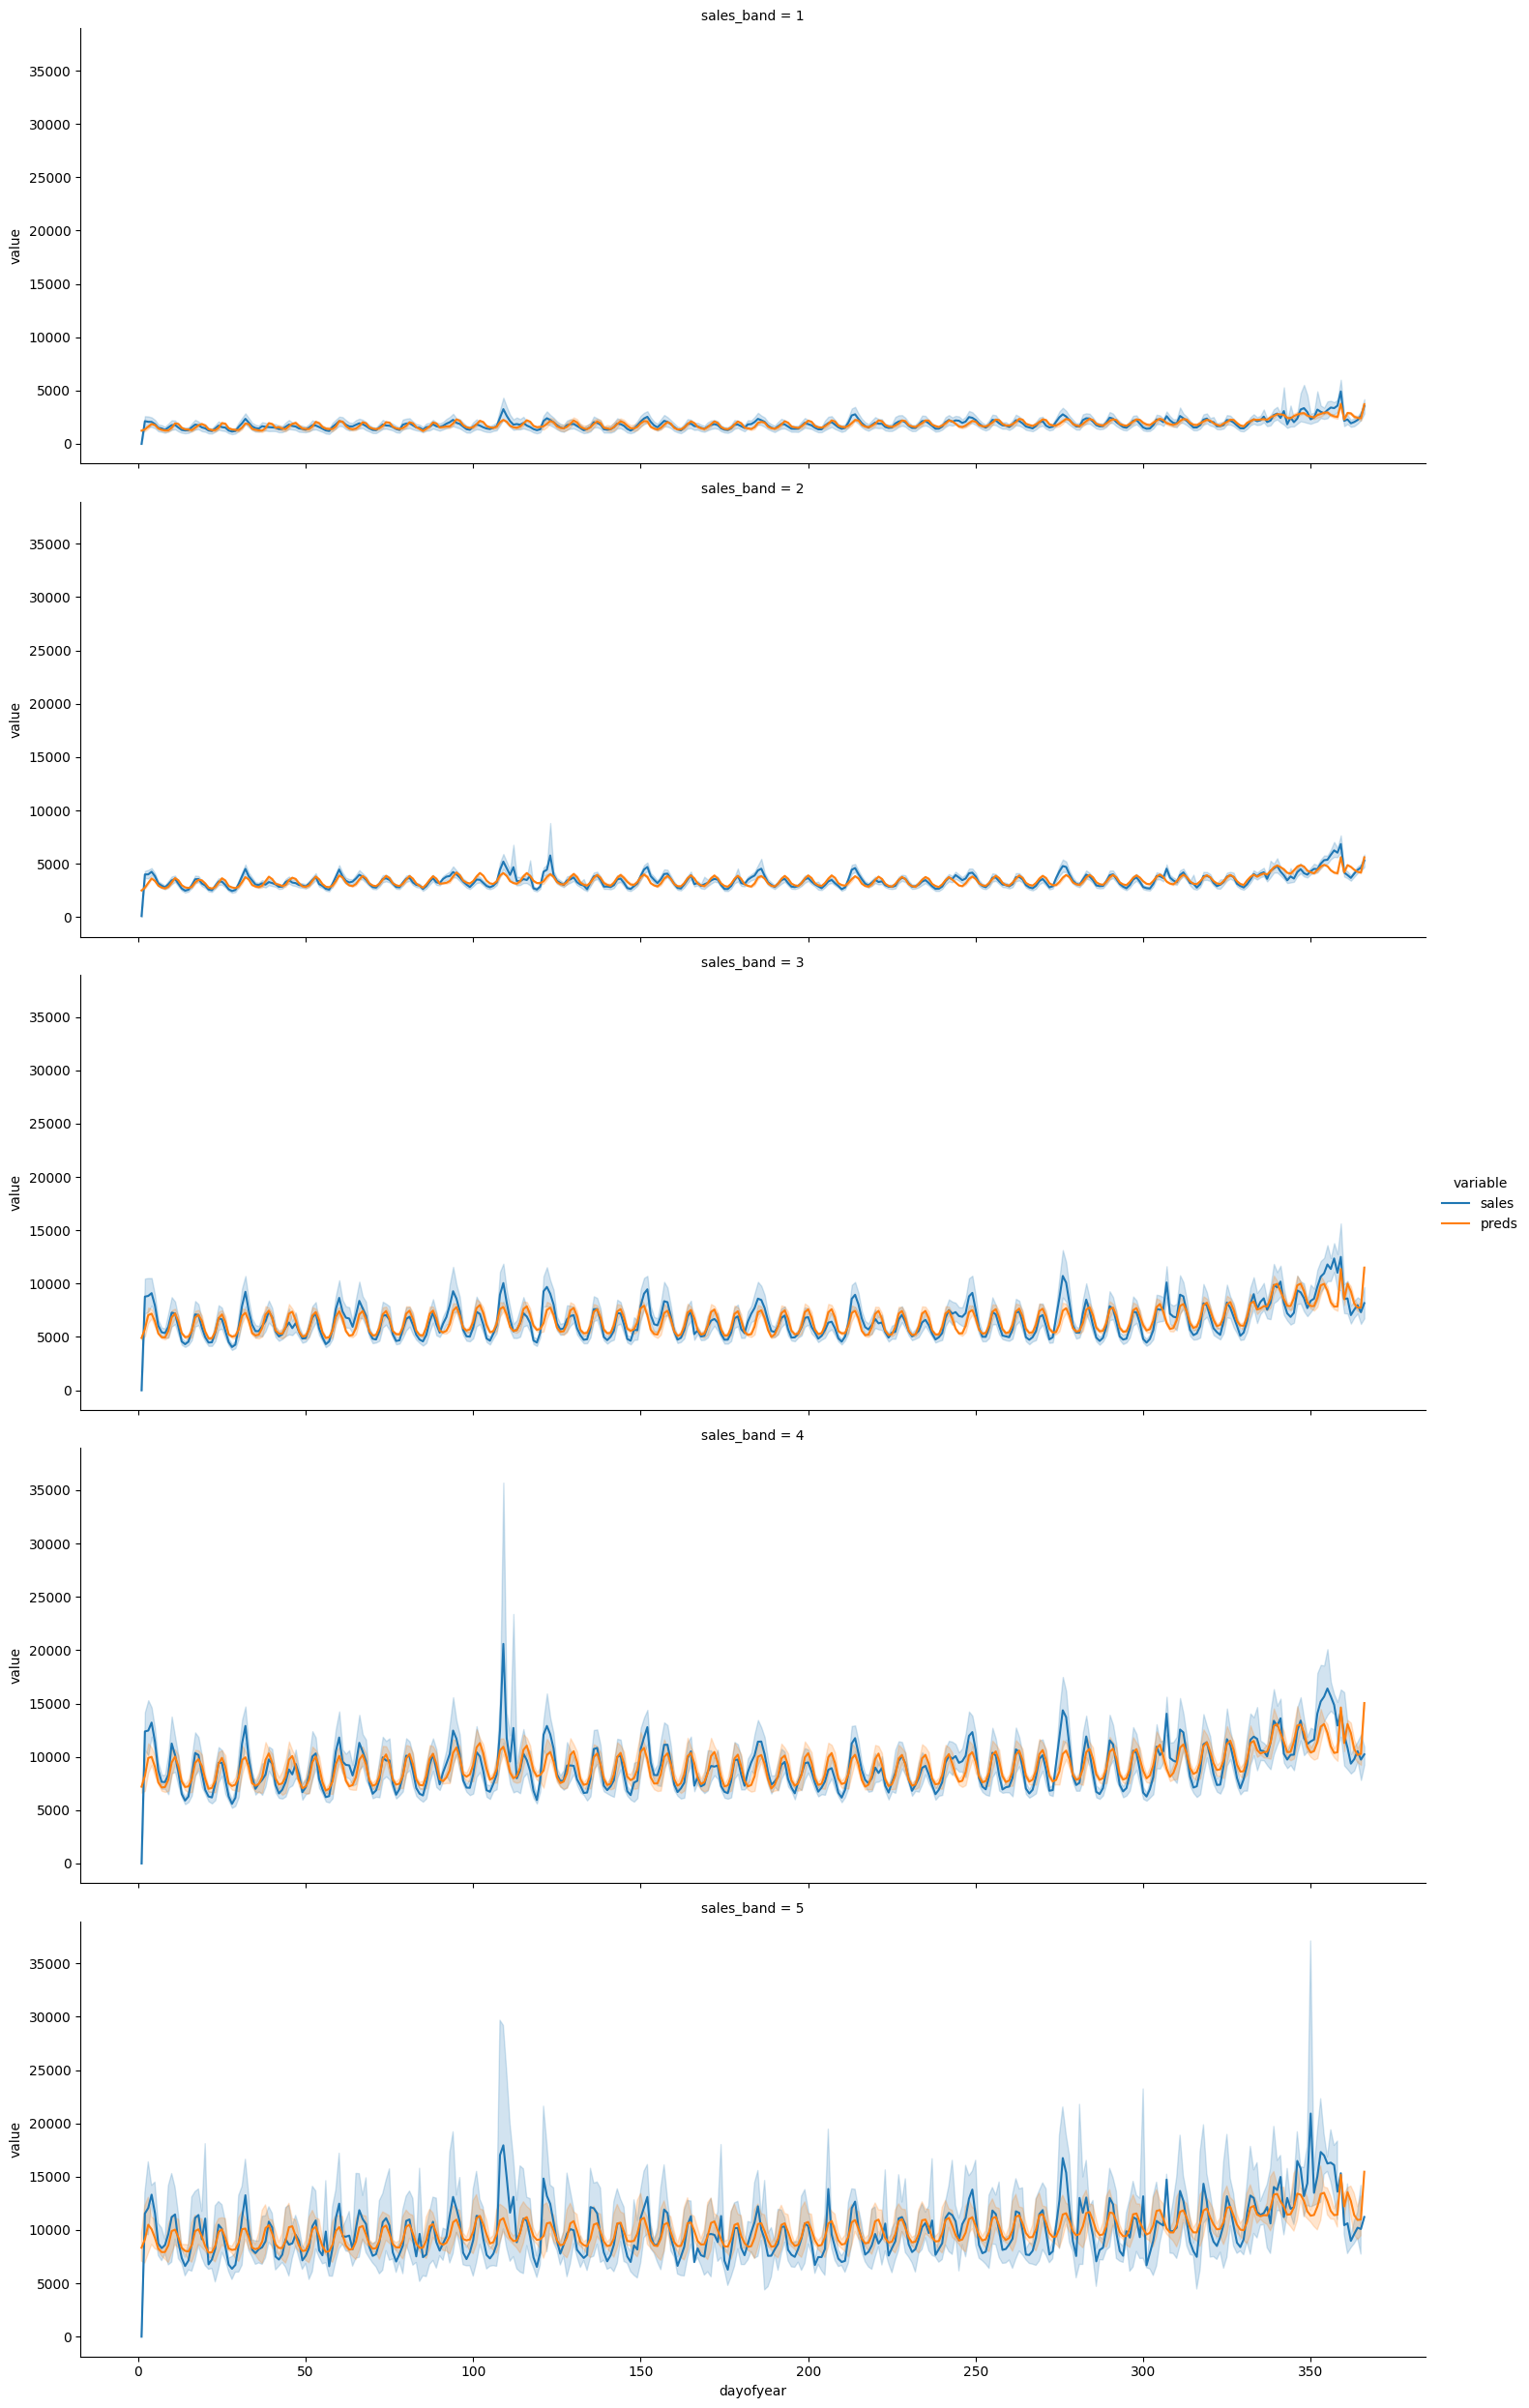

In [17]:
%%time
g = train.copy()
g = g.query('family == "GROCERY I"')
g['preds'] = makePredictions(g, models)

g = g[['sales_band', 'sales', 'preds', 'dayofyear']]
g = pd.melt(g, id_vars=['sales_band', 'dayofyear'])

sns.relplot(g, x='dayofyear', y='value', hue='variable'
            , row='sales_band'
            , kind='line', aspect=3);

# > Questioning the zeros
Do I train the model without the zeros? Do I train each family and cluster separately?
Yes, you need to train the model for each family. And the zeros matter.

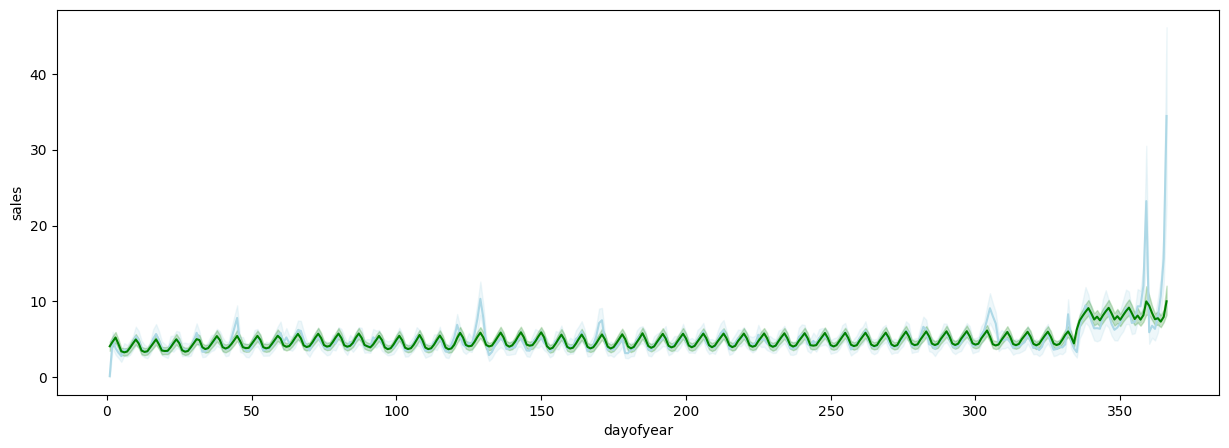

In [18]:
g = train.copy()
g = g.query('family == "LAWN AND GARDEN"')
g['preds'] = makePredictions(g, models)
# g = g.query('store_type == "A"')
# g = g.loc[g[target] != 0]
# g_pp = pipe.transform(g)
# g_model = LinearRegression()
# g_model.fit(g_pp, g[target])
# g['preds_nonzero'] = g_model.predict(g_pp)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=g, x='dayofyear', y=target, ax=ax, color='lightblue');
# sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax, color='orange');
sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax, color='green');

# > Submission

In [19]:
samp = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
samp = cleanData(samp, store_type, oil_price, holidays, sales_band)

pd.DataFrame({
    'id': samp['id']
    , 'sales': makePredictions(samp, models)
}).to_csv('submission.csv', index=False)

In [20]:
# %%time
# train['preds'] = makePredictions(train, models)
# train['dataset'] = 'train'
# test['preds'] = makePredictions(test, models)
# test['dataset'] = 'test'

# samp['preds'] = makePredictions(samp, models)
# samp['dataset'] = 'sample'
# export = pd.concat([train, test, samp], axis=0)
# # # %load_ext autoreload
# # # %autoreload 2
# import datawarehouse as dw
# dw.uploadData(export, "storesales_v07")